# Objective:

Comparing DNN ensemble model as a benchmark and LSTM model using same sets of Train and Test datas. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

2023-03-30 14:51:04.481604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import Libraries for reading data
import epftoolbox_1
from epftoolbox_1.data import read_data
from epftoolbox_1.data import DataScaler

In [3]:
# Import Libraries for Model Evaluation
from epftoolbox.evaluation import MAE 
from epftoolbox.evaluation import RMSE 
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE

# LSTM Model for Nord Pool Market

In [4]:
# Load data into dataframe
df_train, df_test = read_data(path='.', dataset='NP', begin_test_date='12/27/2016', end_test_date='12/24/2018')
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


Text(0, 0.5, 'Price')

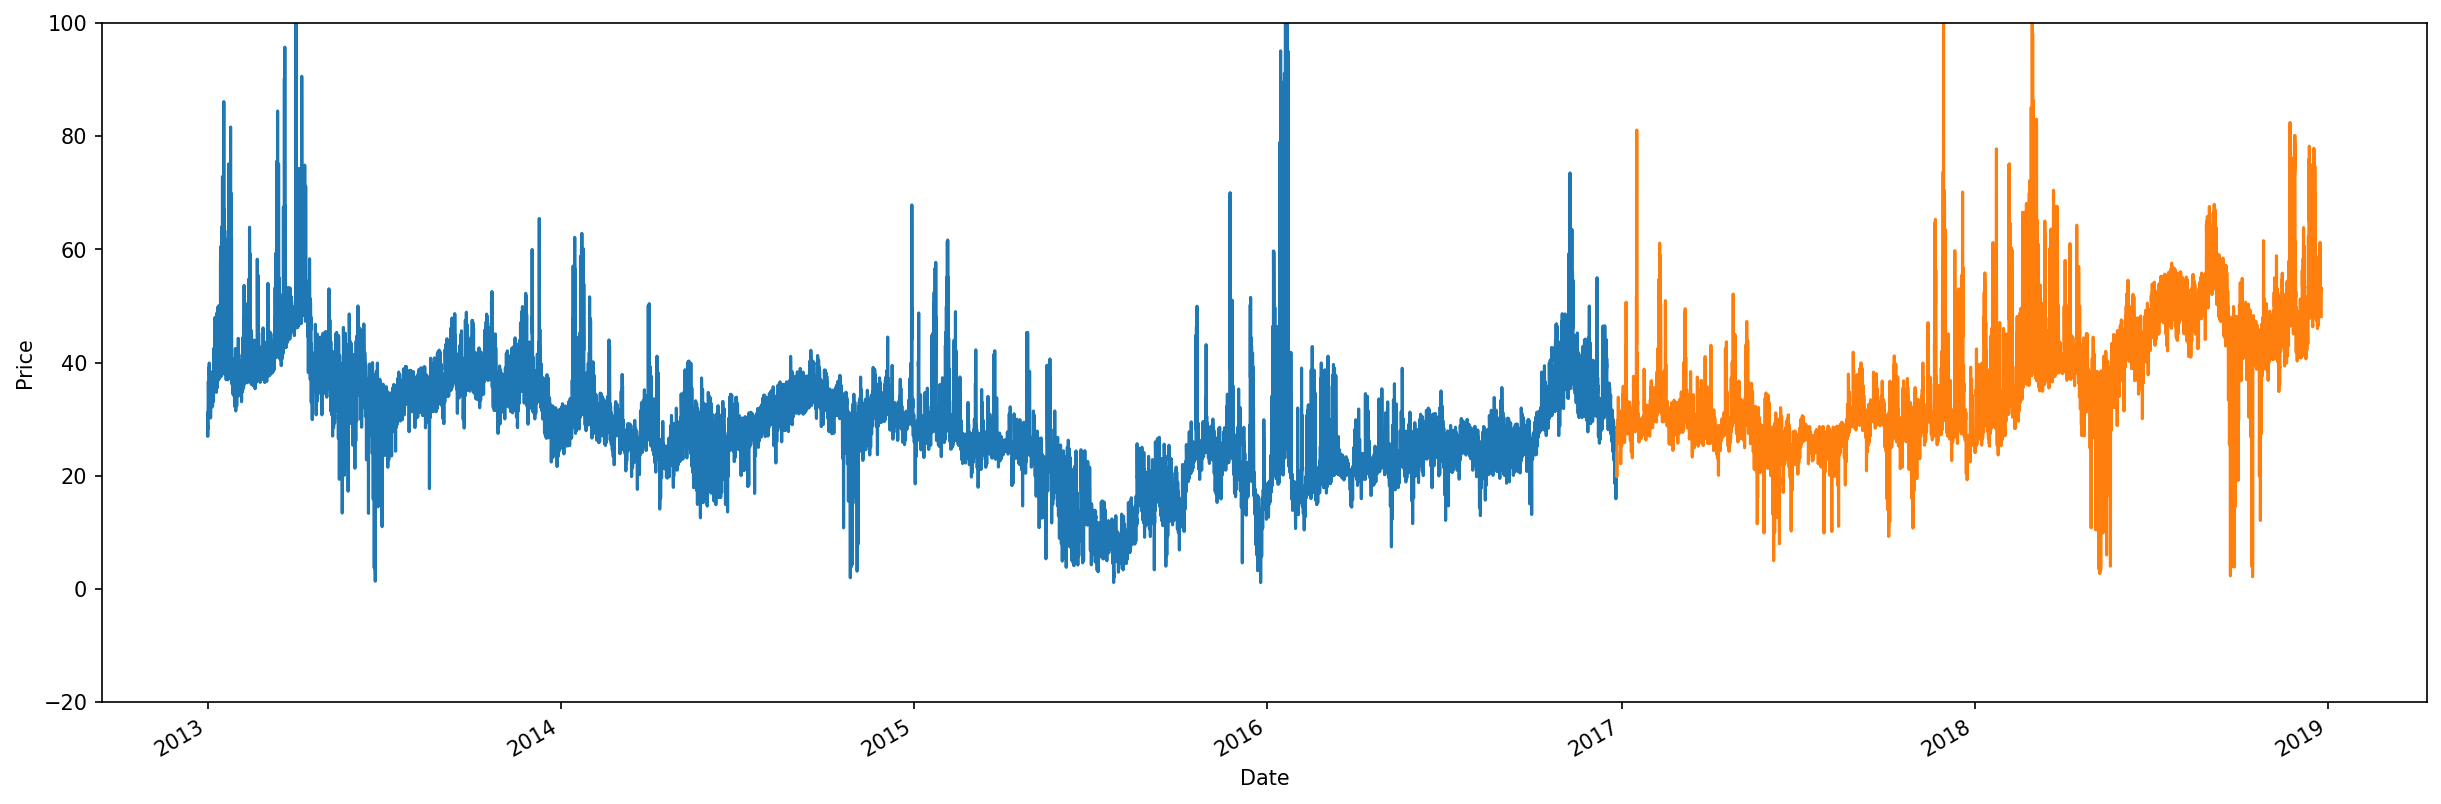

In [5]:
import matplotlib.pyplot as plt

# ploting Train (Blue) and Test (Orange) data

plt.figure(figsize=(20,6) ,dpi=150)

plt.plot(df_train.Price)
plt.plot(df_test.Price)
plt.ylim(-20, 100)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')

In [6]:
look_back = 1
# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]
Xtest = pd.concat([df_train.iloc[-look_back:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)
#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape), Xtest.shape
print('Test Dimension : ', Xtest.shape)

Train Dimension :  (34944, 1)
Test Dimension :  (17473, 1)


In [7]:
# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

In [8]:
# Function to create data for LSTM
def create_lstm_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

In [9]:
# Create data for LSTM

train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
test_X, test_y = create_lstm_data(Xtest_scaled, look_back)

# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [ ]:
# Create LSTM model

#Start Time
st = time.time()
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit and Train LSTM model
model.fit(train_X, train_y, epochs=5, batch_size=1, verbose=2)

#End time 
et = time.time()


2023-03-30 14:51:26.768819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
34943/34943 - 115s - loss: 2.0138e-04 - 115s/epoch - 3ms/step
Epoch 2/5
34943/34943 - 101s - loss: 1.5021e-04 - 101s/epoch - 3ms/step
Epoch 3/5


In [ ]:
# Predict next values for testing set
test_predict = model.predict(test_X)

# Invert scaling for predictions and actual values
predicted = scaler.inverse_transform(test_predict)

In [ ]:
#Creating Data for Observed and Predicted Values 
res = pd.DataFrame(Xtest[1:], index=Xtest.index[1:])
res['Predicted'] = predicted

In [ ]:
# ploting Observed and predicted values for 10 days 
plt.figure(figsize=(20,6) ,dpi=150)

ax1 = res.Price.plot(color='orange', grid=True, secondary_y=True, label='Observed')
ax2 = res.Predicted.plot(color='blue', grid=True, label='Predicted')
ax1.set_ylim(0, 60)
ax2.set_ylim(0, 60)
plt.xlim([datetime.date(2017, 1, 1), datetime.date(2017, 1, 10)])
plt.xticks(rotation=30, ha='right')
plt.title('Observed vs Predicted - NP Price')
plt.xlim([datetime.date(2017, 1, 1), datetime.date(2017, 1, 10)])
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Model Evaluation for LSTM
MAE_l = MAE(p_pred=res.Predicted, p_real=res.Price)
RMSE_l = RMSE(p_pred=res.Predicted, p_real=res.Price)
MAPE_l = MAPE(p_pred=res.Predicted, p_real=res.Price) * 100
sMAPE_l = sMAPE(p_pred=res.Predicted, p_real=res.Price) * 100
MASE_l = MASE(p_pred=res.Predicted, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l = rMAE(p_pred=res.Predicted, p_real=res.Price)

# DNN ensemble Model for Nord Pool Market

In [ ]:
# Read and predict using benchmark DNN model in the paper 
forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' +
                     'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
# Transforming indices to datetime format
forecast.index = pd.to_datetime(forecast.index)
# Reading data from the NP market
df_train, df_test = read_data(path='.', dataset='NP', begin_test_date=forecast.index[0],
                        end_test_date=forecast.index[-1])
#predicted price
fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
#Real price
real_price = df_test.loc[:, ['Price']]

In [ ]:
#Model Evaluation for DNN in Paper
MAE_p = MAE(p_pred=fc_DNN_ensemble, p_real=real_price)
RMSE_p = RMSE(p_pred=fc_DNN_ensemble, p_real=real_price)
MAPE_p = MAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
sMAPE_p = sMAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
MASE_p = MASE(p_pred=fc_DNN_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_p = rMAE(p_pred=fc_DNN_ensemble, p_real=real_price)

## Summary table for Model evaluation

In [ ]:
#Summary table for Model evaluation
from tabulate import tabulate
print(tabulate([['Mean Absolute Error (MAE):', MAE_p ,MAE_l], 
                ['Root Mean Square Error (RMSE):',RMSE_p,RMSE_l],
                ['Mean Absolute Percentage Error (MAPE):',MAPE_p,MAPE_l],
               ['symmetric Mean Absolute Percentage Error (sMAPE):',sMAPE_p,sMAPE_l],
                ['Mean Absolute Scaled Error (MASE):',MASE_p,MASE_l],
                ['relative Mean Absolute Error(rMAE):',rMAE_p,rMAE_l]],headers=['Model Evaluation for Nord Pool (NP) Market','DNN_ensemble','LSTM']))

In [ ]:
print(tabulate([['Time:', '8-20 min' ,str(round((et-st)/60,2))+' min']]
               ,headers=['Elapsed Time','DNN_ensemble', 'LSTM']))

## Conclusion 

The evaluation results indicate that there was no significant difference between the performance of the LSTM model and the benchmark DNN ensemble model, which were both trained and tested using the same dataset and methods. Therefore, this suggests that the LSTM model could be a viable option for this particular task.

However, it is important to keep in mind that the performance of these models may vary depending on the specific task and dataset. Further testing and experimentation may be necessary to determine the best model for a given application.